In [78]:
print(h5py.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(skimage.__version__)
print(torch.__version__)

3.8.0
1.23.5
3.6.3
0.19.3
1.13.1


In [77]:
import matplotlib
import skimage

In [2]:
import h5py
import numpy as np

f = h5py.File('dataset.hdf5','r')
Hi = f['trnOrg']
P = f['trnMask']

Fourier_Masked = [
    P[i,:,:]*np.fft.fft2(Hi[i,:,:]) for i in range(360)
]
Lo = [
    np.fft.ifft2(pfx) for pfx in Fourier_Masked
]

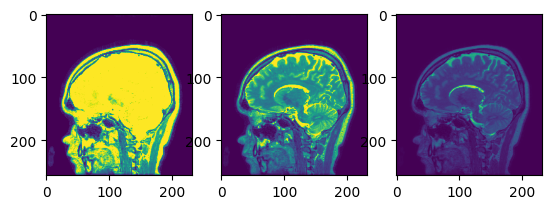

In [6]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3)
ax0 = ax[0].imshow(colorize(Hi[0],lb=-.2,ub=.2)[0,:,:])
ax1 = ax[1].imshow(colorize(Hi[0],lb=-.5,ub=.5)[0,:,:])
ax2 = ax[2].imshow(colorize(Hi[0],lb=-2,ub=2)[0,:,:])

In [69]:
# strategy 1 - just grayscale
def colorize(pic,lb=-0.5,ub=0.5, option='draw', plot=False):
    Ab = np.abs(pic)
    
    def normalize(A):
        return (A-np.min(A))/(np.max(A)-np.min(A))
    def clip_n_normalize(A):
        return normalize(np.clip(A,lb,ub))
        
    
    if plot:
        plt.hist(Re,c='r',label='Real')
        plt.hist(Im,c='b',label='Imag')
        plt.hist(Ab,c='g',label='Abs')
    
    A = np.array([clip_n_normalize(Ab)])
    return A#[np.newaxis,:,:]

def MassColorize(Data):
    return np.array([colorize(data) for data in Data])

Hi_colorized = MassColorize(Hi)
Lo_colorized = MassColorize(Lo)

In [56]:
from skimage.metrics import structural_similarity as sk_ssim
from skimage.metrics import peak_signal_noise_ratio as sk_psnr


def psnr0(hi, hihat, max_val=1.):
    if type(hihat)!=type(np.array([1,2,3])):
        hi = hi.detach().numpy()
        hihat = hihat.detach().numpy()
    rmse = np.sqrt(np.mean((hi-hihat)**2))
    if rmse == 0:
        return 100
    else:
        return 20*np.log10(max_val/rmse)
    
def psnr(his, hihats):
    his = his.detach().numpy()
    hihats = hihats.detach().numpy()
    batch_size = his.shape[0]
    psnrs = []
    for i in range(batch_size):
        psnrs.append(
            sk_psnr(his[i,0,:,:],hihats[i,0,:,:])
        )
    return np.array(psnrs).sum()
    
def ssim(his, hihats):
    his = his.detach().numpy()
    hihats = hihats.detach().numpy()
    batch_size = his.shape[0]
    ssims = []
    for i in range(batch_size):
        ssims.append(
            sk_ssim(his[i,0,:,:],hihats[i,0,:,:])
        )
    return np.array(ssims).sum()
    
    
print(Hi_colorized[:3,0,:,:].shape) # sample_size, width, height

print(Hi_colorized.shape) # sample_size, channel_size, width, height
print(Tensorize(Hi_colorized).shape)
    
print(psnr(Tensorize(Hi_colorized[:36,:,:]), Tensorize(Lo_colorized[:36,:,:]))/36)
print(sk_psnr(Hi_colorized[:36,:,:], Lo_colorized[:36,:,:]))
print(ssim(Tensorize(Hi_colorized[:3,:,:]), Tensorize(Lo_colorized[:3,:,:]))/36)



(3, 256, 232)
(360, 1, 256, 232)
torch.Size([360, 1, 256, 232])
18.527759348592422
18.450848936022496
0.03057707509632737


/var/folders/_4/6qb0x2vs2lz5gz55b1_h00n80000gn/T/ipykernel_37801/495715044.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(sk_psnr(Hi_colorized[:36,:,:], Lo_colorized[:36,:,:]))


# Model

In [8]:
import torch.nn
import torch.nn.functional as F

class VNL(torch.nn.Module):
    def __init__(self):
        super(VNL, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=9,
                                    padding=2,padding_mode='replicate')
        self.conv2 = torch.nn.Conv2d(64,32,kernel_size=1,
                                    padding=2,padding_mode='replicate')
        self.conv3 = torch.nn.Conv2d(32,1,kernel_size=5,
                                    padding=2,padding_mode='replicate')
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        return x
            

In [9]:
tr, val = torch.utils.data.random_split(list(zip(
    Hi_colorized,Lo_colorized
)), [0.7,0.3])
Train = [tr.dataset[i] for i in tr.indices]
Val = [val.dataset[i] for i in val.indices]

In [10]:
batch_size = 32

Tensorize = lambda _ : torch.tensor(_, dtype=torch.float32)

class myImage(torch.utils.data.Dataset):
    def __init__(self, images):
        super().__init__()
        self.listOfXYPairs = images
        self.len = len(images)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        pair = self.listOfXYPairs[idx]
        return (Tensorize(Train[0][0]), Tensorize(Train[0][1]))

# data shuffle. Training shuffling is important
        
Tr_DL = torch.utils.data.DataLoader(myImage(Train),
                                    batch_size= batch_size)
Val_DL = torch.utils.data.DataLoader(myImage(Val), 
                                    batch_size= batch_size)


In [61]:
epochs = 80
lr = 7e-3

model = VNL()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

def train(model, DL, export=False): # train with one batch
    model.train()
    loss_cul = .0
    psnr_cul = .0
    ssim_cul = .0
    
    for hi,lo in DL:
        optimizer.zero_grad()
        hihat = model(lo)
        loss = criterion(hihat, hi)
        
        loss.backward()
        optimizer.step()
        
        loss_cul += loss.item()
        batch_psnr = psnr(hi,hihat)
        psnr_cul += batch_psnr
        batch_ssim = ssim(hi,hihat)
        ssim_cul += batch_ssim
        print(loss.item(), batch_psnr/hi.shape[0], batch_ssim/hi.shape[0])
        
    loss_fin = loss_cul/len(DL.dataset)
    psnr_fin = psnr_cul/len(DL.dataset)
    ssim_fin = ssim_cul/len(DL.dataset)
    if export:
        return loss_fin, psnr_fin, ssim_fin, model
    else:
        return loss_fin, psnr_fin, ssim_fin
    
def val(model, DL): # train with one batch
    model.eval()
    loss_cul = .0
    psnr_cul = .0
    ssim_cul = .0
    
    with torch.no_grad():
        for hi,lo in DL:
            hihat = model(lo)
            loss = criterion(hihat, hi)

            loss_cul += loss.item()
            batch_psnr = psnr(hi,hihat)
            psnr_cul += batch_psnr
            batch_ssim = ssim(hi,hihat)
            ssim_cul += batch_ssim
        
    loss_fin = loss_cul/len(DL.dataset)
    psnr_fin = psnr_cul/len(DL.dataset)
    ssim_fin = ssim_cul/len(DL.dataset)
    return loss_fin, psnr_fin, ssim_fin


In [62]:
import time

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
train_ssim, val_ssim = [], []
model_evo = [model]

start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    if epoch%10==0:
        train_epoch_loss, train_epoch_psnr, train_epoch_ssim, model_fossil = train(model, Tr_DL, export=True)
        model_evo.append(model_fossil)
    else:
        train_epoch_loss, train_epoch_psnr, train_epoch_ssim = train(model, Tr_DL)
    val_epoch_loss, val_epoch_psnr, val_epoch_ssim = val(model, Val_DL)
    
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    train_ssim.append(train_epoch_ssim)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    val_ssim.append(val_epoch_ssim)
    
    
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 80
0.08451849222183228 10.730482966142853 0.20590024097742746
0.0316624641418457 14.994553239618835 0.20565165108484726
0.05328619107604027 12.733853376147481 0.23292190215611583
0.023751311004161835 16.243123510342247 0.2541577513312052
0.03552936762571335 14.494125712912911 0.42330223752187185
0.01856212131679058 17.31372327922981 0.4067734932919062
0.012941515073180199 18.88014946013292 0.32352751808274866
0.022878164425492287 16.40578797534818 0.3246793587197853
Epoch 2 of 80
0.011898630298674107 19.245030530423836 0.5921186718658459
0.012603710405528545 18.99501610641698 0.3139174909076782
0.017017411068081856 17.69106513932224 0.25424271426340755
0.014110908843576908 18.50445063364243 0.33669863627929875
0.010222955606877804 19.904234882052815 0.5469938291734546
0.010562079958617687 19.76250524040928 0.5285692467341181
0.013104775920510292 18.82570391429912 0.40137818160757205
0.012294766493141651 19.102797054432777 0.3736144691954631
Epoch 3 of 80
0.01047428697347641 

Epoch 18 of 80
0.00615323893725872 22.108962409586358 0.7767006241763135
0.00614410825073719 22.115411286513318 0.7777607977255716
0.006134779192507267 22.122010412606457 0.7786778791726111
0.006125119049102068 22.12885505781637 0.7793155957900247
0.006114977411925793 22.136050937392678 0.7802679830069207
0.006104408297687769 22.143564291946163 0.780955115011397
0.006093746516853571 22.151155734117612 0.7811915765076258
0.006083335727453232 22.158582073289576 0.7815136261554515
Epoch 19 of 80
0.0060732075944542885 22.165818734662718 0.7819202471652889
0.006063067354261875 22.173076550805906 0.7824040202116819
0.006052759010344744 22.180465739826726 0.782651428914207
0.0060422951355576515 22.18798153362979 0.7831949456655163
0.006031885277479887 22.195469153298134 0.7836833691991582
0.006021827459335327 22.20271724144848 0.7843498152697648
0.006012402940541506 22.209519362052035 0.7843807803113961
0.006004272494465113 22.215396077179083 0.7853779457469771
Epoch 20 of 80
0.00600025663152

Epoch 35 of 80
0.005481004249304533 22.611399077588334 0.7680472522352679
0.005455485079437494 22.63166632128554 0.7911899296115927
0.005549730267375708 22.557281490848954 0.7562494678699259
0.0054678283631801605 22.621851361759568 0.785269367751211
0.005437218584120274 22.64623147840402 0.7835556029241518
0.00547863868996501 22.613273708412937 0.7988616467017806
0.0054268138483166695 22.654550621702562 0.8030926297031409
0.005420367699116468 22.65971248382944 0.8054629252751854
Epoch 36 of 80
0.005461821798235178 22.626624819208367 0.7979145435786072
0.005436699837446213 22.646646166201375 0.7866752409569824
0.005393085069954395 22.681626861670992 0.7939706534461687
0.005418597254902124 22.66113146441928 0.7950460218526011
0.005430697929114103 22.651442964119198 0.7912872708051597
0.0053761061280965805 22.69532176765683 0.8048441173242734
0.005389778409153223 22.68429126572422 0.7983455272035498
0.00541356997564435 22.66516303391497 0.8061535125331175
Epoch 37 of 80
0.0053934659808874

Epoch 52 of 80
0.0051041156984865665 22.920794692601074 0.8171791469774382
0.005101291928440332 22.923198425450074 0.8157524128981198
0.005098686553537846 22.92541678950635 0.817331446691787
0.005096462555229664 22.9273115139641 0.8165711744924001
0.005094519350677729 22.92896779437929 0.8172029685117964
0.005092688836157322 22.930528497029382 0.8173026137859025
0.005091033410280943 22.931940343698795 0.8166467962168421
0.0050895255990326405 22.93322708688625 0.817557135023869
Epoch 53 of 80
0.005088097415864468 22.93444550866075 0.8164029690610591
0.005086921621114016 22.935449371790714 0.8176151619438841
0.005086180754005909 22.936081756294744 0.8161945864696682
0.0050859334878623486 22.936293031844524 0.8175268324071097
0.005086768884211779 22.935579910483067 0.8145449475402392
0.005089587066322565 22.93317436999122 0.8161494934547165
0.0050964392721652985 22.927331952261483 0.8081776853814325
0.005110936239361763 22.91499483241852 0.8084845665520206
Epoch 54 of 80
0.005139647517353

Epoch 69 of 80
0.005015376955270767 22.99696467313592 0.8087527801591524
0.004919585771858692 23.080715102035057 0.8126180772139666
0.004938072524964809 23.06442537246511 0.8201633636643698
0.005005061626434326 23.005905568858047 0.8042240308777808
0.004990034736692905 23.01896410433163 0.7910547245438787
0.004927125759422779 23.074062680047376 0.8128647480935633
0.004907151218503714 23.091705984322747 0.8221025168977727
0.004945770837366581 23.057659981478377 0.80000165227841
Epoch 70 of 80
0.004973388742655516 23.033475418655676 0.8048802108130113
0.0049442751333117485 23.058973268128273 0.8064373198671481
0.0049064564518630505 23.092320467302724 0.82182938070409
0.00490617286413908 23.092571944454026 0.8196461010927198
0.004930115770548582 23.07142810248633 0.8112527311773954
0.0049329171888530254 23.068961950740423 0.8172113453723754
0.004908265080302954 23.090719728517456 0.8175640645819362
0.0048930407501757145 23.104212228824185 0.8231741391417297
Epoch 71 of 80
0.00489929411560

(360, 1, 256, 232)


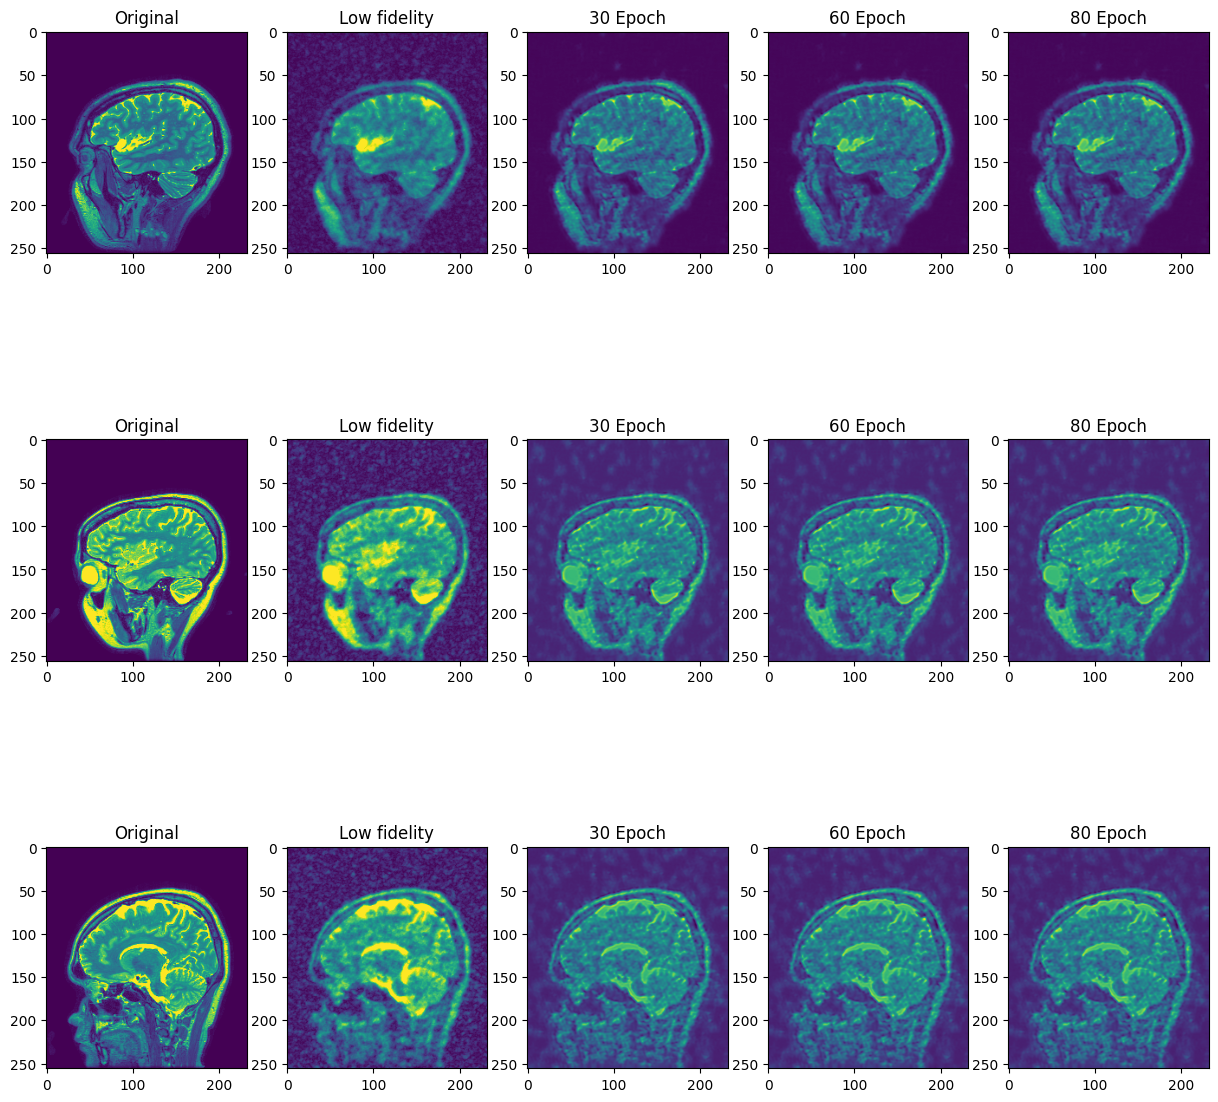

In [67]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,5,figsize=(15,15))

print(Hi_colorized.shape)
for i in range(3):
    ax[i,0].imshow(Train[10*i][0][0,:,:])
    ax[i,1].imshow(Train[10*i][1][0,:,:])
    ax[i,2].imshow(
        np.einsum('kij -> ijk', model_evo[3](
            Tensorize(Train[10*i][1])
        ).detach().numpy())
    )
    ax[i,3].imshow(
        np.einsum('kij -> ijk', model_evo[6](
            Tensorize(Train[10*i][1])
        ).detach().numpy())
    )
    ax[i,4].imshow(
        np.einsum('kij -> ijk', model(
            Tensorize(Train[10*i][1])
        ).detach().numpy())
    )
    
    ax[i,0].set_title('Original')
    ax[i,1].set_title('Low fidelity')
    ax[i,2].set_title('30 Epoch')
    ax[i,3].set_title('60 Epoch')
    ax[i,4].set_title('80 Epoch')
    
    

(360, 1, 256, 232)


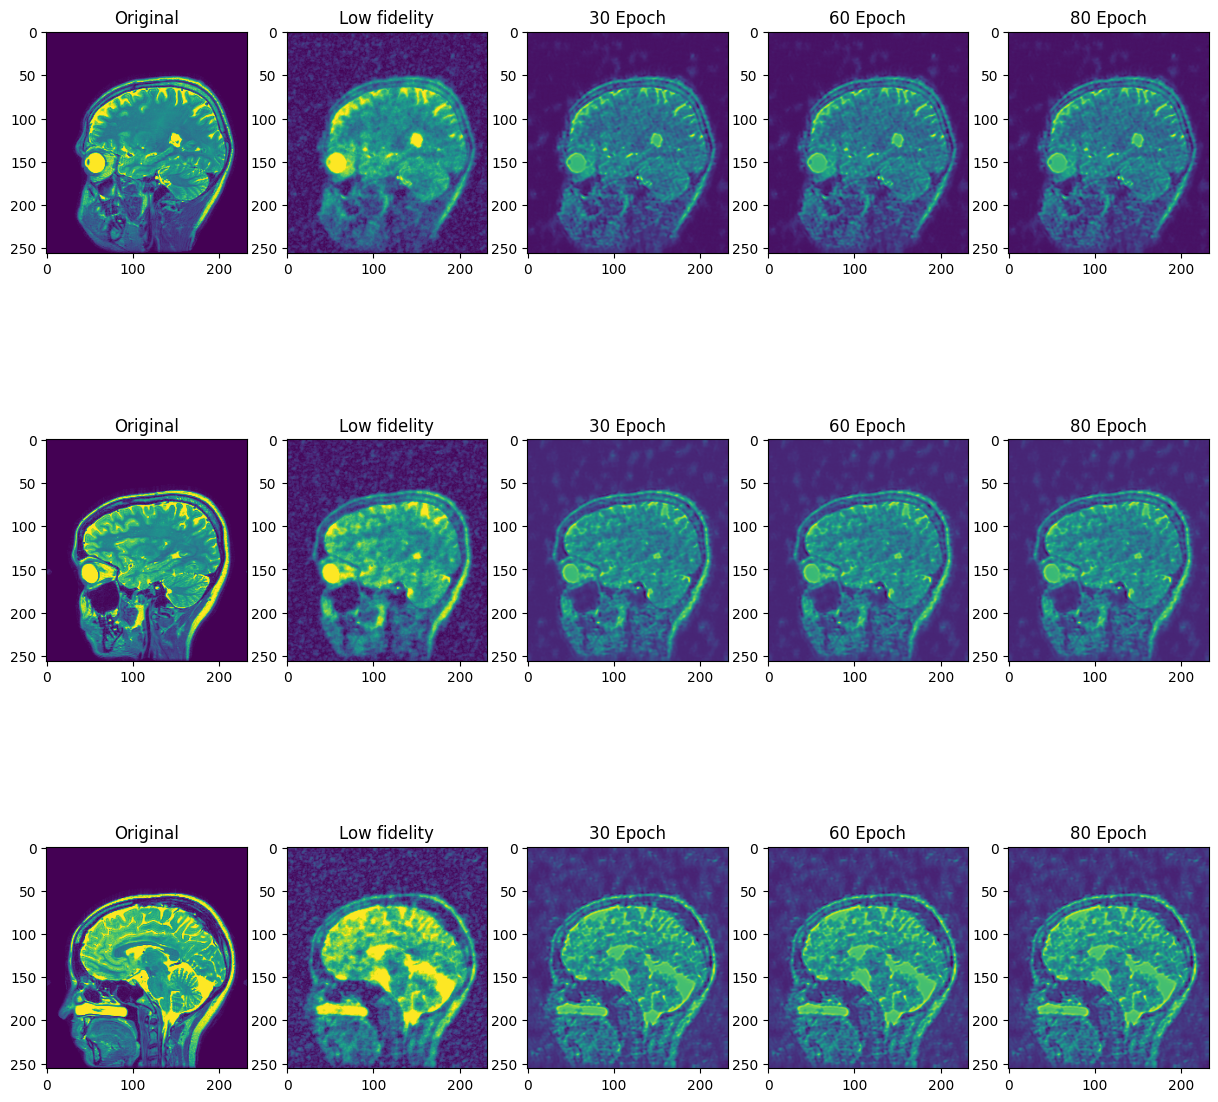

In [68]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,5,figsize=(15,15))

print(Hi_colorized.shape)
for i in range(3):
    ax[i,0].imshow(Val[10*i][0][0,:,:])
    ax[i,1].imshow(Val[10*i][1][0,:,:])
    ax[i,2].imshow(
        np.einsum('kij -> ijk', model_evo[3](
            Tensorize(Val[10*i][1])
        ).detach().numpy())
    )
    ax[i,3].imshow(
        np.einsum('kij -> ijk', model_evo[6](
            Tensorize(Val[10*i][1])
        ).detach().numpy())
    )
    ax[i,4].imshow(
        np.einsum('kij -> ijk', model(
            Tensorize(Val[10*i][1])
        ).detach().numpy())
    )
    
    ax[i,0].set_title('Original')
    ax[i,1].set_title('Low fidelity')
    ax[i,2].set_title('30 Epoch')
    ax[i,3].set_title('60 Epoch')
    ax[i,4].set_title('80 Epoch')
    

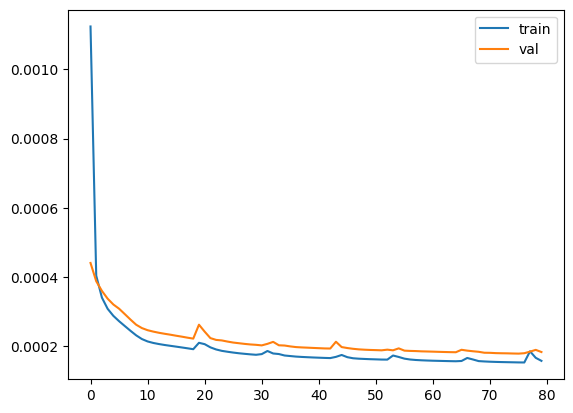

In [64]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()

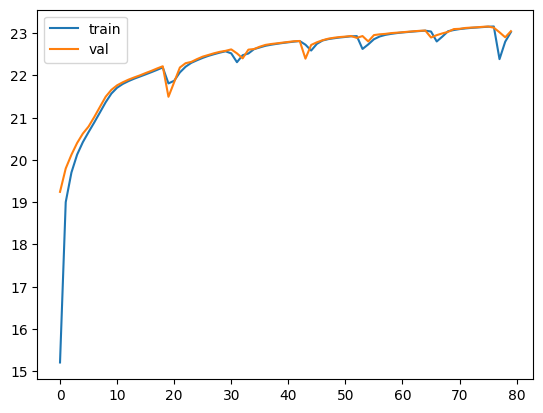

In [65]:
plt.plot(train_psnr,label='train')
plt.plot(val_psnr,label='val')
plt.legend()

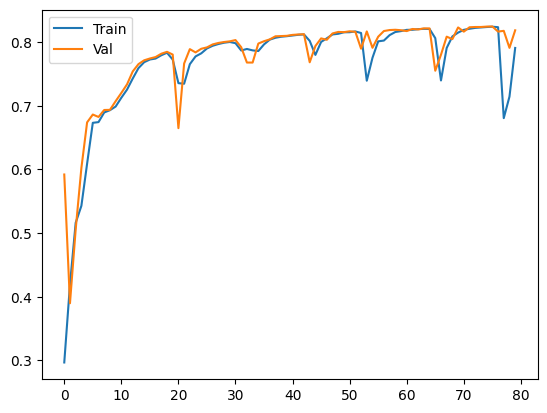

In [66]:
plt.plot(train_ssim,label='Train')
plt.plot(val_ssim,label='Val')
plt.legend()